# Sequence-to-sequence modeling for machine translation with recurrent neural networks

In [17]:
skip_training = False  # Set this flag to True before validation and submission

In [2]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import tools
import tests

from IPython.display import Image, display

In [3]:
data_dir = tools.select_data_dir()

The data directory is ../data


In [4]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

## Data

The dataset consists of pairs of sentences in French and English.

In [5]:
from data import TranslationDataset, MAX_LENGTH, SOS_token, EOS_token

trainset = TranslationDataset(data_dir, train=True)

Extracting ../data\translation_data.zip to ../data



* `TranslationDataset` supports indexing as required by `torch.utils.data.Dataset`.
* Sentences are tensors of maximum length `MAX_LENGTH`.
* Words in a (sentence) tensor are represented as an index (integer) in a language vocabulary.
* The string representation of a word from the source language can be obtained from index `i` with `dataset.input_lang.index2word[i]`.
* Similarly for the target language `dataset.output_lang.index2word[j]`.

Let's look at samples from that dataset.

In [6]:
src_sentence, tgt_sentence = trainset[np.random.choice(len(trainset))]
print('Source sentence: "%s"' % ' '.join(trainset.input_lang.index2word[i.item()] for i in src_sentence))
print('Sentence as tensor of word indices:')
print(src_sentence)

print('Target sentence: "%s"' % ' '.join(trainset.output_lang.index2word[i.item()] for i in tgt_sentence))
print('Sentence as tensor of word indices:')
print(tgt_sentence)

Source sentence: "je suis un agent . EOS"
Sentence as tensor of word indices:
tensor([  6,  11,  66, 435,   5,   1])
Target sentence: "i m an agent . EOS"
Sentence as tensor of word indices:
tensor([  2,   3, 247, 249,   4,   1])


In [7]:
print('Number of source-target pairs in the training set: ', len(trainset))

Number of source-target pairs in the training set:  8682


## Sequence-to-sequence model for machine translation

In this notebook, I am going to build a machine translation system which transforms a sentence in one language into a sentence in another one. The computational graph of the translation model is shown below:


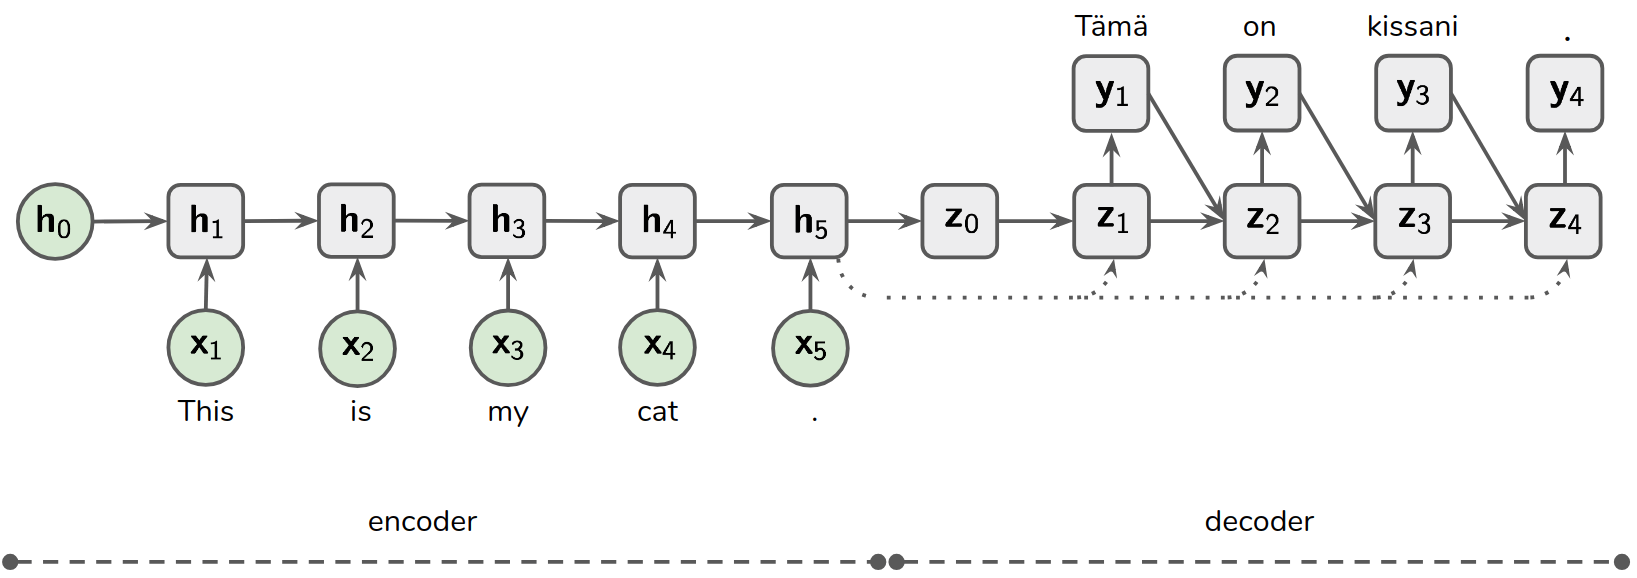

In [2]:
display(Image(filename='images/seq2seq.png', embed=True))

I am going to use a simplified model without the dotted connections.

## Custom DataLoader

The sequence-to-sequence model is trained using mini-batch training.
One difficulty of mini-batch training in this case is that sequences may have varying lengths and this has to be taken into account when building the computational graph. Luckily, PyTorch has tools to support batch processing of such sequences.
To use those tools, I write a custom data loader which puts sequences of varying lengths in the same tensor. The data loader can be customized by providing a custom `collate_fn` as explained [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

The collate function:
- combines sequences from the source language in a single tensor with extra values (at the end) filled with `padding_value=0`.
- combines sequences from the target language in a single tensor with extra values (at the end) filled with `padding_value=0`.

**Important**:
- Later in the code (not in this `collate` function), I will convert source sequences to objects of class [`PackedSequence`](https://pytorch.org/docs/stable/nn.html?highlight=packedsequence#torch.nn.utils.rnn.PackedSequence) which can be processed by recurrent units such as `GRU` or `LSTM`. `PackedSequence` requires sequences to be sorted by their lengths.
**Therefore, the returned source sequences should be sorted by length in a decreasing order.**
* The target sequences need not be sorted by their lengths because the same order of sequences in the source and target tensors needed to be kept.



In [8]:
padding_value = 0

In [10]:
from torch.nn.utils.rnn import pad_sequence

def collate(list_of_samples):
    """Merges a list of samples to form a mini-batch.

    Args:
      list_of_samples is a list of tuples (src_seq, tgt_seq):
          src_seq is of shape (src_seq_length,)
          tgt_seq is of shape (tgt_seq_length,)

    Returns:
      src_seqs of shape (max_src_seq_length, batch_size): Tensor of padded source sequences.
          The sequences should be sorted by length in a decreasing order, that is src_seqs[:,0] should be
          the longest sequence, and src_seqs[:,-1] should be the shortest.
      src_seq_lengths: List of lengths of source sequences.
      tgt_seqs of shape (max_tgt_seq_length, batch_size): Tensor of padded target sequences.
    """
    sorted_list = sorted(list_of_samples, key =  lambda x: len(x[0]),reverse=True)
    src_seq = pad_sequence([sample[0] for sample in sorted_list],padding_value=padding_value)
    src_seq_lengths = [len(sample[0])for sample in sorted_list]    
    tgt_seqs = pad_sequence([sample[1] for sample in sorted_list],padding_value=padding_value)
    return src_seq,src_seq_lengths,tgt_seqs

In [11]:
# create custom DataLoader using the implemented collate function
# a training loop processes 64 sequences at the same time (batch_size=64)
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=True, collate_fn=collate, pin_memory=True)

## Encoder

The encoder encodes a source sequence $(x_1, x_2, ..., x_T)$ into a single vector $h_T$ using the following recursion:
$$
  h_{t} = f(h_{t-1}, x_t) \qquad t = 1, \ldots, T
$$
where:
* intial state $h_0$ is often chosen arbitrarily (I choose it to be zero)
* function $f$ is defined by the type of the RNN cell (I will use [GRU](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU))
* $x_t$ is a vector that represents the $t$-th word in the source sentence.

A common practice in natural language processing is to _learn_ the word representations $x_t$ (instead of, for example, using one-hot coded vectors). In PyTorch, this is supported by class [Embedding](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding) which I am going to use.

The computational graph of the encoder is shown below:



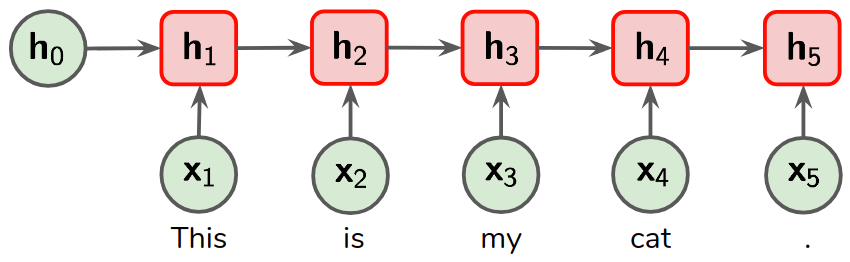

In [3]:
display(Image(filename='images/seq2seq_encoder.png', embed=True))

In [12]:
class Encoder(nn.Module):
    def __init__(self, src_dictionary_size, embed_size, hidden_size):
        """
        Args:
          src_dictionary_size: The number of words in the source dictionary.
          embed_size: The number of dimensions in the word embeddings.
          hidden_size: The number of features in the hidden state of GRU.
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(src_dictionary_size, embed_size)
        self.gru = nn.GRU(input_size=embed_size, hidden_size=hidden_size)

    def forward(self, pad_seqs, seq_lengths, hidden):
        """
        Args:
          pad_seqs of shape (max_seq_length, batch_size): Padded source sequences.
          seq_lengths: List of sequence lengths.
          hidden of shape (1, batch_size, hidden_size): Initial states of the GRU.

        Returns:
          outputs of shape (max_seq_length, batch_size, hidden_size): Padded outputs of GRU at every step.
          hidden of shape (1, batch_size, hidden_size): Updated states of the GRU.
        """
        outputs = self.embedding(pad_seqs)
        outputs= pack_padded_sequence(outputs,seq_lengths)
        outputs, new_hidden = self.gru(outputs,hidden)
        outputs,_ = pad_packed_sequence(outputs)
        return outputs,new_hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size)

## Decoder

The decoder takes as input the representation computed by the encoder and transforms it into a sentence in the target language. The computational graph of the decoder is shown below:


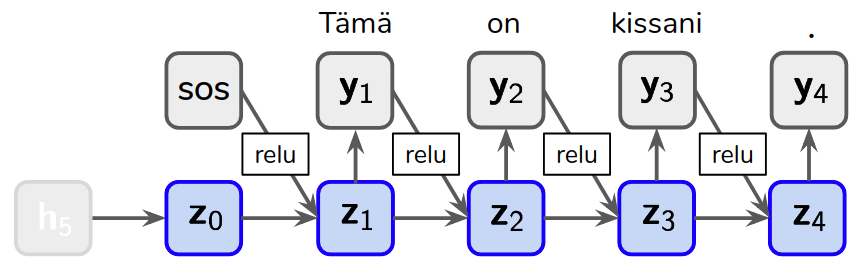

In [4]:
display(Image(filename='images/seq2seq_decoder.png', embed=True))

* $z_0$ is the output of the encoder, that is $z_0 = h_5$, thus `hidden_size` of the decoder should be the same as `hidden_size` of the encoder.
* $y_{i}$ are the log-probabilities of the words in the target language, the dimensionality of $y_{i}$ is the size of the target dictionary.
* $z_{i}$ is mapped to $y_{i}$ using a linear layer `self.out` followed by `F.log_softmax` (because we use `nn.NLLLoss` loss for training).
* Each cell of the decoder is a GRU, it receives as inputs the previous state $z_{i-1}$ and relu of the **embedding** of the previous word. Thus, we need to embed the words of the target language as well. The previous word is taken as the word with the maximum log-probability.

Note that the decoder outputs a word at every step and the same word is used as the input to the recurrent unit at the next step. At the beginning of decoding, the previous word input is fed with a special word SOS which stands for "start of a sentence". During training, we know the target sentence for decoding, therefore we can feed the correct words $y_i$ as inputs to the recurrent unit.

When the target sentence is fed to the decoder during training, the decoder learns to generate only the next word (this scenario is called "teacher forcing"). At test time, the decoder works differently: it generates the whole sequence using its own predictions as inputs at each step. Therefore, it makes sense to train the decoder to produce full sentences. In order to do that, I will alternate between two modes during training:
* "teacher forcing": the decoder is fed with the words in the target sequence
* no "teacher forcing": the decoder generates the output sequence using its own predictions. We will limit the maximum length of generated sequences to `MAX_LENGTH`.


In [13]:
class Decoder(nn.Module):
    def __init__(self, tgt_dictionary_size, embed_size, hidden_size):
        """
        Args:
          tgt_dictionary_size: The number of words in the target dictionary.
          embed_size: The number of dimensions in the word embeddings.
          hidden_size: The number of features in the hidden state.
        """
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(tgt_dictionary_size, embed_size)
        self.gru = nn.GRU(input_size=embed_size, hidden_size=hidden_size)
        self.out = nn.Linear(hidden_size, tgt_dictionary_size)

    def forward(self, hidden, pad_tgt_seqs=None, teacher_forcing=False):
        """
        Args:
          hidden of shape (1, batch_size, hidden_size): States of the GRU.
          pad_tgt_seqs of shape (max_out_seq_length, batch_size): Tensor of words (word indices) of the
              target sentence. If None, the output sequence is generated by feeding the decoder's outputs
              (teacher_forcing has to be False).
          teacher_forcing (bool): Whether to use teacher forcing or not.

        Returns:
          outputs of shape (max_out_seq_length, batch_size, tgt_dictionary_size): Tensor of log-probabilities
              of words in the target language.
          hidden of shape (1, batch_size, hidden_size): New states of the GRU.

        """
        if pad_tgt_seqs is None:
            assert not teacher_forcing, 'Cannot use teacher forcing without a target sequence.'
            batch_size = hidden.shape[1]
            sequence_index = []
            sequence_log = []
            SOS = torch.zeros([1,batch_size]).type(torch.LongTensor)
            sequence_index.append(SOS)   
            for i in range(MAX_LENGTH):
                outputs = self.embedding(sequence_index[i])
                outputs = F.relu(outputs)
                outputs, hidden = self.gru(outputs,hidden)
                outputs = self.out(outputs)
                outputs = F.log_softmax(outputs,dim=2)
                output_index = torch.Tensor([[torch.argmax(i[j]).item() for j in range(batch_size)] for i in outputs])
                output_index = output_index.type(torch.LongTensor)
                sequence_index.append(output_index)
                sequence_log.append(outputs)
            out = torch.cat(sequence_log,dim=0)
        else:
            batch_size = hidden.shape[1]
            if teacher_forcing:
                SOS = torch.zeros([1,batch_size]).type(torch.LongTensor)
                outputs = torch.cat([SOS,pad_tgt_seqs[:pad_tgt_seqs.shape[0]-1,:]],dim = 0)
                outputs = self.embedding(outputs)
                outputs =F.relu(outputs)
                outputs, hidden = self.gru(outputs,hidden)
                out = F.log_softmax(self.out(outputs),dim=2)
                
            else:
                sequence_index = []
                sequence_log = []
                SOS = torch.zeros([1,batch_size]).type(torch.LongTensor)
                sequence_index.append(SOS)
                for i in range(pad_tgt_seqs.shape[0]):
                    outputs = self.embedding(sequence_index[i])
                    outputs = F.relu(outputs)
                    outputs, hidden = self.gru(outputs,hidden)   
                    outputs = self.out(outputs)
                    outputs = F.log_softmax(outputs,dim=2)
                    output_index = torch.Tensor([[torch.argmax(i[j]).item() for j in range(batch_size)] for i in outputs])
                    output_index = output_index.type(torch.LongTensor)
                    sequence_index.append(output_index)
                    sequence_log.append(outputs)               
                out = torch.cat(sequence_log,dim=0)
        return out, hidden

## Training of sequence-to-sequence model using mini-batches

In [14]:
# Create the seq2seq model
hidden_size = embed_size = 256
encoder = Encoder(trainset.input_lang.n_words, embed_size, hidden_size).to(device)
decoder = Decoder(trainset.output_lang.n_words, embed_size, hidden_size).to(device)

In [15]:
teacher_forcing_ratio = 0.5

In the training loop, I first encode source sequences using the encoder, then I decode the encoded state using the decoder. The decoder outputs log-probabilities of words in the target language. I use these log-probabilities and the indexes of the words in the target sequences to compute the loss.

Hyperparameters:
- Encoder optimizer: Adam with learning rate 0.001
- Decoder optimizer: Adam with learning rate 0.001
- Number of epochs: 30
- Toggle `teacher_forcing` on and off (for each mini-batch) according to the `teacher_forcing_ratio` specified above.


In [20]:
if not skip_training:
    encoder_optimizer = torch.optim.Adam(encoder.parameters(),lr=0.001)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(),lr=0.001)
    n_epochs = 30
    loss_method = nn.NLLLoss(ignore_index =0,reduction='mean')
    batch_size = 64
    
    for epoch in range(n_epochs):
        for i, data in enumerate(trainloader, 0):
            src_seqs,src_seq_lengths,tgt_seqs = data 
            if src_seqs.shape[1] < batch_size:
                break
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            encoder.zero_grad()
            decoder.zero_grad()   
            hidden = encoder.init_hidden(batch_size=batch_size)
            encoder_outputs, new_hidden = encoder.forward(pad_seqs=src_seqs, seq_lengths=src_seq_lengths, hidden=hidden) 
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False 
            if use_teacher_forcing:
                outputs, _ = decoder.forward(new_hidden, tgt_seqs, teacher_forcing=True)
            else:
                outputs, _ = decoder.forward(new_hidden, tgt_seqs, teacher_forcing=False)
            loss = loss_method(outputs.view(-1, outputs.shape[2]),tgt_seqs.view(-1))    
            loss.backward()
            encoder_optimizer.step() 
            decoder_optimizer.step()

        print('Train Epoch {}: Loss: {:.6f}'.format(epoch, loss.item()))      

Train Epoch 0: Loss: 2.903968
Train Epoch 1: Loss: 2.347890
Train Epoch 2: Loss: 2.005840
Train Epoch 3: Loss: 1.704509
Train Epoch 4: Loss: 1.992323
Train Epoch 5: Loss: 1.725326
Train Epoch 6: Loss: 1.343894
Train Epoch 7: Loss: 1.129550
Train Epoch 8: Loss: 1.410103
Train Epoch 9: Loss: 0.588447
Train Epoch 10: Loss: 0.926818
Train Epoch 11: Loss: 0.611448
Train Epoch 12: Loss: 0.625227
Train Epoch 13: Loss: 0.691261
Train Epoch 14: Loss: 0.479805
Train Epoch 15: Loss: 0.358603
Train Epoch 16: Loss: 0.430047
Train Epoch 17: Loss: 0.334633
Train Epoch 18: Loss: 0.191664
Train Epoch 19: Loss: 0.203555
Train Epoch 20: Loss: 0.194945
Train Epoch 21: Loss: 0.235861
Train Epoch 22: Loss: 0.221478
Train Epoch 23: Loss: 0.115109
Train Epoch 24: Loss: 0.095919
Train Epoch 25: Loss: 0.117036
Train Epoch 26: Loss: 0.125136
Train Epoch 27: Loss: 0.039837
Train Epoch 28: Loss: 0.060734
Train Epoch 29: Loss: 0.136491


## Save model to disk

In [21]:
if not skip_training:
    tools.save_model(encoder, '5_encoder.pth')
    tools.save_model(decoder, '5_decoder.pth')
else:
    hidden_size = 256
    encoder = Encoder(trainset.input_lang.n_words, embed_size, hidden_size)
    tools.load_model(encoder, '5_encoder.pth', device)
    
    decoder = Decoder(trainset.output_lang.n_words, embed_size, hidden_size)
    tools.load_model(decoder, '5_decoder.pth', device)

Do you want to save the model (type yes to confirm)? yes
Model saved to 5_encoder.pth.
Do you want to save the model (type yes to confirm)? yes
Model saved to 5_decoder.pth.


## Evaluation

Next I implement a function that converts a source sequence to an output sequence using the trained sequence-to-sequence model.

In [22]:
def translate(encoder, decoder, src_seq):
    """Translate given sentence src_seq using trained encoder and decoder.
    
    Args:
      encoder (Encoder): Trained encoder.
      decoder (Decoder): Trained decoder.
      src_seq of shape (src_seq_length,): LongTensor of word indices of the source sequence.
    
    Returns:
      out_seq of shape (out_seq_length,): LongTensor of word indices of the output sequence.
    """    
    hidden = encoder.init_hidden(batch_size=1)
    encoder_outputs, new_hidden = encoder.forward(pad_seqs=src_seq.view(src_seq.shape[0],1), seq_lengths=[src_seq.shape[0]], hidden=hidden)
    outputs, new_hidden = decoder.forward(new_hidden, None, teacher_forcing=False)   
    out_seq = torch.Tensor([torch.argmax(i).item() for i in outputs])
    return out_seq                                                                                           
                    

Let's translate random sentences from the training set and print the source, target, and produced output.

In [23]:
# Translate random sentences from the training set
print('Translate training data:')
print('-----------------------------')
for i in range(5):
    src_sentence, tgt_sentence = trainset[np.random.choice(len(trainset))]
    print('SRC:', ' '.join(trainset.input_lang.index2word[i.item()] for i in src_sentence))
    print('TGT:', ' '.join(trainset.output_lang.index2word[i.item()] for i in tgt_sentence))
    out_sentence = translate(encoder, decoder, src_sentence)
    print('OUT:', ' '.join(trainset.output_lang.index2word[i.item()] for i in out_sentence))
    print('')

Translate training data:
-----------------------------
SRC: je ne suis pas autorise a vous aider . EOS
TGT: i m not allowed to help you . EOS
OUT: i m not allowed to help you . EOS EOS

SRC: nous sommes en train de bouger . EOS
TGT: we re moving . EOS
OUT: we re moving . EOS EOS EOS EOS EOS EOS

SRC: nous sommes desormais pour ainsi dire mortes . EOS
TGT: we re as good as dead now . EOS
OUT: we re as good as dead now . EOS EOS

SRC: il est vraiment fondu de foot . EOS
TGT: he s really into soccer . EOS
OUT: he s really into soccer . EOS EOS EOS EOS

SRC: je suis tres contente de vous revoir . EOS
TGT: i m very glad to see you again . EOS
OUT: i m very glad to see you again . EOS



Now translate random sentences from the test set.

In [24]:
testset = TranslationDataset(data_dir, train=False)

In [25]:
print('Translate test data:')
print('-----------------------------')
for i in range(5):
    src_sentence, tgt_sentence = testset[np.random.choice(len(testset))]
    print('SRC:', ' '.join(testset.input_lang.index2word[i.item()] for i in src_sentence))
    print('TGT:', ' '.join(testset.output_lang.index2word[i.item()] for i in tgt_sentence))
    out_sentence = translate(encoder, decoder, src_sentence)
    print('OUT:', ' '.join(testset.output_lang.index2word[i.item()] for i in out_sentence))
    print('')

Translate test data:
-----------------------------
SRC: nous attendons les vacances avec impatience . EOS
TGT: we are looking forward to the holidays . EOS
OUT: we are going to the whole bug . EOS EOS

SRC: je suis en train de perdre mon temps . EOS
TGT: i am wasting my time . EOS
OUT: i m taking my time . EOS EOS EOS EOS

SRC: elle est tres receptive a la suggestion hypnotique . EOS
TGT: she s very susceptible to hypnotic suggestion . EOS
OUT: she is very to her by marriage . EOS EOS

SRC: vous me faites de l ombre . EOS
TGT: you re blocking my light . EOS
OUT: you re blocking my light . EOS EOS EOS EOS

SRC: nous allons jouer au tennis . EOS
TGT: we re going to play tennis . EOS
OUT: we re going to eat right now . EOS EOS

